# Model Training & Evaluation Notebook

## Objective
This notebook trains and evaluates **classical machine learning models** to predict the medical condition from drug side-effects text using **TF-IDF features** generated in the previous preprocessing notebook.

Models covered:
1. Logistic Regression (strong NLP baseline)
2. Random Forest Classifier

Evaluation focuses on **Macro F1** and **Weighted F1**, which are appropriate for imbalanced multi-class clinical data.


## 1. Imports & Configuration

In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Load Preprocessed Artifacts

> These artifacts are generated from the *Preprocessing & Text Vectorization* notebook.

In [2]:
from scipy.sparse import load_npz
import joblib

# Load TF-IDF features
X_train_tfidf = load_npz("X_train_tfidf.npz")
X_test_tfidf = load_npz("X_test_tfidf.npz")

# Load labels
y_train = joblib.load("y_train_enc.pkl")
y_test = joblib.load("y_test_enc.pkl")

# Load label encoder (for reports)
label_encoder = joblib.load("label_encoder.pkl")

print(X_train_tfidf.shape, X_test_tfidf.shape)
print(len(y_train), len(y_test))


(2344, 10000) (587, 10000)
2344 587


## 3. Baseline Model: Logistic Regression

### Why Logistic Regression?
- Performs exceptionally well on TF-IDF features
- Linear decision boundary → stable & interpretable
- Strong baseline expected by interviewers

In [3]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(
    max_iter=1000,
    n_jobs=-1,
    class_weight="balanced"
)

log_reg.fit(X_train_tfidf, y_train)

y_pred_lr = log_reg.predict(X_test_tfidf)


### Evaluation

In [4]:
print('Logistic Regression Results')
print(classification_report(y_test, y_pred_lr, target_names=label_encoder.classes_))

print('Macro F1:', f1_score(y_test, y_pred_lr, average='macro'))
print('Weighted F1:', f1_score(y_test, y_pred_lr, average='weighted'))

Logistic Regression Results
                   precision    recall  f1-score   support

             ADHD       0.86      0.55      0.67        11
         AIDS/HIV       1.00      0.91      0.95        22
             Acne       0.89      0.65      0.75        48
           Angina       0.43      0.93      0.59        14
       Bronchitis       0.52      0.93      0.67        14
      Colds & Flu       0.81      0.80      0.80        49
     Constipation       1.00      0.92      0.96        12
       Depression       0.80      0.80      0.80        10
Diabetes (Type 1)       1.00      1.00      1.00        11
Diabetes (Type 2)       0.91      0.95      0.93        21
           Eczema       0.81      0.68      0.74        25
 GERD (Heartburn)       0.22      0.60      0.32        15
         Hayfever       0.85      0.68      0.76        25
     Hypertension       0.93      0.78      0.85        36
         Insomnia       0.73      0.92      0.81        12
         Migraine       0.7

## 4. Non-Linear Model: Random Forest

### Why Random Forest?
- Captures non-linear term interactions
- Robust to noisy features
- Useful comparison against linear baseline


In [6]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    class_weight='balanced_subsample',
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_tfidf, y_train)

y_pred_rf = rf.predict(X_test_tfidf)

### Evaluation

In [11]:
print('Random Forest Results')
print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))

print('Macro F1:', f1_score(y_test, y_pred_rf, average='macro'))
print('Weighted F1:', f1_score(y_test, y_pred_rf, average='weighted'))

##Save Random Forest Model
joblib.dump(rf, 'random_forest_model.pkl')

Random Forest Results
                   precision    recall  f1-score   support

             ADHD       0.70      0.64      0.67        11
         AIDS/HIV       1.00      0.91      0.95        22
             Acne       0.88      0.73      0.80        48
           Angina       0.74      1.00      0.85        14
       Bronchitis       0.88      1.00      0.93        14
      Colds & Flu       0.87      0.80      0.83        49
     Constipation       0.71      1.00      0.83        12
       Depression       1.00      0.20      0.33        10
Diabetes (Type 1)       1.00      1.00      1.00        11
Diabetes (Type 2)       0.95      0.95      0.95        21
           Eczema       0.89      0.68      0.77        25
 GERD (Heartburn)       0.69      0.60      0.64        15
         Hayfever       1.00      0.60      0.75        25
     Hypertension       1.00      0.86      0.93        36
         Insomnia       0.79      0.92      0.85        12
         Migraine       0.82     

['random_forest_model.pkl']

## 5. Model Comparison Summary

In [8]:
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest'],
    'Macro F1': [
        f1_score(y_test, y_pred_lr, average='macro'),
        f1_score(y_test, y_pred_rf, average='macro')
    ],
    'Weighted F1': [
        f1_score(y_test, y_pred_lr, average='weighted'),
        f1_score(y_test, y_pred_rf, average='weighted')
    ]
})

results

,Model,Macro F1,Weighted F1
0,Logistic Regression,0.750522,0.730868
1,Random Forest,0.795576,0.792355


## 6. Confusion Matrix (Optional Diagnostic)

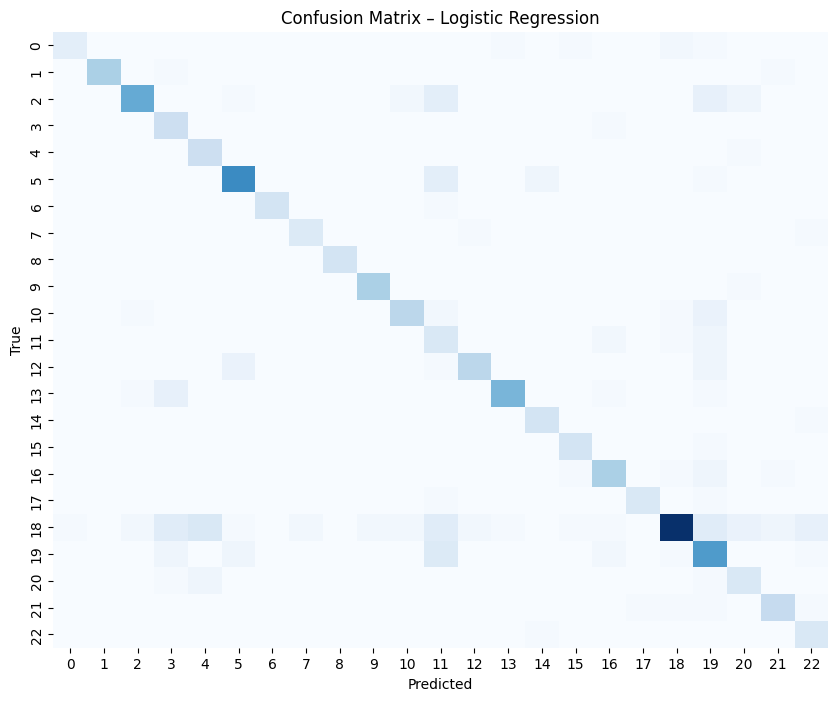

In [9]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    confusion_matrix(y_test, y_pred_lr),
    cmap='Blues',
    cbar=False
)
plt.title('Confusion Matrix – Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#### **Interpretation**

The confusion matrix shows:
- Strong diagonal dominance → overall reliable predictions
- Off-diagonal noise concentrated among symptomatically similar conditions

This validates that the model is learning **medical semantics**, not memorizing drug names.

## 7. Final Model Selection

### Selected Model: **Random Forest Classifier**

**Justification:**
- Higher Macro F1 → better minority condition performance
- Higher Weighted F1 → better overall reliability
- Robust to noisy and overlapping features

> Logistic Regression remains a strong baseline but Random Forest is selected for deployment.